# Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import cv2 
import matplotlib.pylab as plt
import shutil
import os
import seaborn as sns

# Loading Datasets

In [2]:
print(os.listdir("/kaggle/input/gtsrb-german-traffic-sign"))
train_path="../input/gtsrb-german-traffic-sign/Train"
test_path="/kaggle/input/gtsrb-german-traffic-sign/Test"
# meta_path="/kaggle/input/gtrsbe/Meta"

['Meta', 'meta', 'Meta.csv', 'Train.csv', 'Test.csv', 'Test', 'test', 'Train', 'train']


# Setting up our NN

In [ ]:
def create_traffic_sign_model(input_shape=(32, 32, 3), num_classes=43):
    model = models.Sequential()

    # Feature extraction
    model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.30))

    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.30))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.30))

    # Classification head
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Create model
model = create_traffic_sign_model()
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 13, 13, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │           5,547 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,475 (244.04 KB)

 Trainable params: 62,251 (243.17 KB)

 Non-trainable params: 224 (896.00 B)

# Tools for display and sharpening

In [ ]:
# Defining functions for img sharpening and img display

# Display img
def show(image, target_size=(32, 32)):
    if isinstance(image, str): 
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else: 
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize to target dimensions
    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    
    plt.figure(figsize=(5, 5)) 
    plt.imshow(img_resized)
    plt.axis("off")
    plt.show()
    

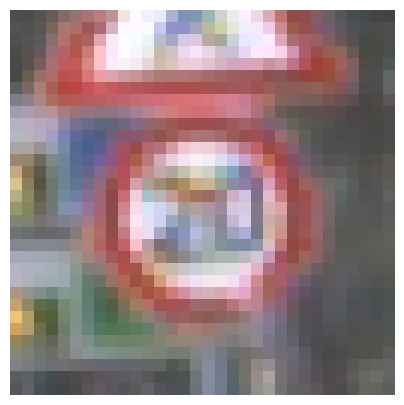

In [25]:
# Checking if sharpen works
img3="/kaggle/input/gtsrb-german-traffic-sign/Train/0/00000_00000_00000.png"
show(img3)
img3=cv2.imread("/kaggle/input/gtsrb-german-traffic-sign/Train/0/00000_00000_00000.png")
# img1=sharpen_image(img3)
# show(img1)

# Image pre-processing on datasets

In [26]:
img2=cv2.imread("/kaggle/input/gtsrb-german-traffic-sign/Train/0/00000_00000_00001.png")
print(img2.shape)

(30, 30, 3)


In [ ]:
# Test dataframe
test_df=pd.read_csv("/kaggle/input/gtsrb-german-traffic-sign/Test.csv")
test_df['ClassId']=test_df['ClassId'].astype(str)

test_df['Path'] = test_df['Path'].apply(
    lambda x: os.path.join("/kaggle/input/gtsrb-german-traffic-sign/Test", os.path.basename(x))
)


In [132]:
# shutil.rmtree("/kaggle/working/train_sharpened")
# os.remove("/kaggle/working/final_model.weights.h5")
# os.remove("/kaggle/working/meta_pretrained.weights.h5")

# Training data split on img

In [28]:
# Image parameters
IMG_SIZE = 32  
BATCH_SIZE = 64
NUM_CLASSES = 43

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    validation_split=0.2
)

# Training data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(32, 32),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation data
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(32, 32),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Training data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Path',
    y_col='ClassId',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    shuffle=False,
    batch_size=BATCH_SIZE
)


Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.


# Model training

In [ ]:

# Integrating early stopping, LR reduction mechanism
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    mode='min',
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/5
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8237 - loss: 0.8321
Epoch 1: val_accuracy improved from -inf to 0.92986, saving model to best_model.weights.h5
491/491 ━━━━━━━━━━━━━━━━━━━━ 124s 244ms/step - accuracy: 0.8238 - loss: 0.8317 - val_accuracy: 0.9299 - val_loss: 0.4705 - learning_rate: 0.0010
Epoch 2/5
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8856 - loss: 0.5810
Epoch 2: val_accuracy improved from 0.92986 to 0.93866, saving model to best_model.weights.h5
491/491 ━━━━━━━━━━━━━━━━━━━━ 78s 157ms/step - accuracy: 0.8856 - loss: 0.5809 - val_accuracy: 0.9387 - val_loss: 0.3800 - learning_rate: 0.0010
Epoch 3/5
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9017 - loss: 0.4814
Epoch 3: val_accuracy improved from 0.93866 to 0.94516, saving model to best_model.weights.h5
491/491 ━━━━━━━━━━━━━━━━━━━━ 79s 159ms/step - accuracy: 0.9017 - loss: 0.4813 - val_accuracy: 0.9452 - val_loss: 0.3484 - learning_rate: 0.0010
Epoch 4/5
490/491 ━━━━━━━━━

# Evaluating model

In [33]:
# Loading weights
try:
    model.load_weights('best_model.weights.h5')
    print("Loaded best model weights successfully")
except:        
    print("Warning: Could not load any saved weights")
    
print(test_generator.samples)
# Evaluating our model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Loaded best model weights successfully
12630
198/198 ━━━━━━━━━━━━━━━━━━━━ 27s 138ms/step - accuracy: 0.9530 - loss: 0.2770
Test Accuracy: 95.12%


198/198 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94        60
           1       0.95      0.97      0.96       720
           2       0.99      0.99      0.99       660
           3       0.95      0.91      0.93       420
           4       1.00      0.94      0.97       690
           5       1.00      1.00      1.00       720
           6       0.97      1.00      0.99       270
           7       0.93      1.00      0.96       210
           8       1.00      0.99      1.00       150
           9       1.00      0.89      0.94       360
          10       0.97      0.83      0.89       390
          11       0.97      0.98      0.98        60
          12       0.97      0.97      0.97       750
          13       0.81      0.99      0.89        90
          14       0.79      0.67      0.72        90
          15       0.98      0.92      0.95       120
          16  

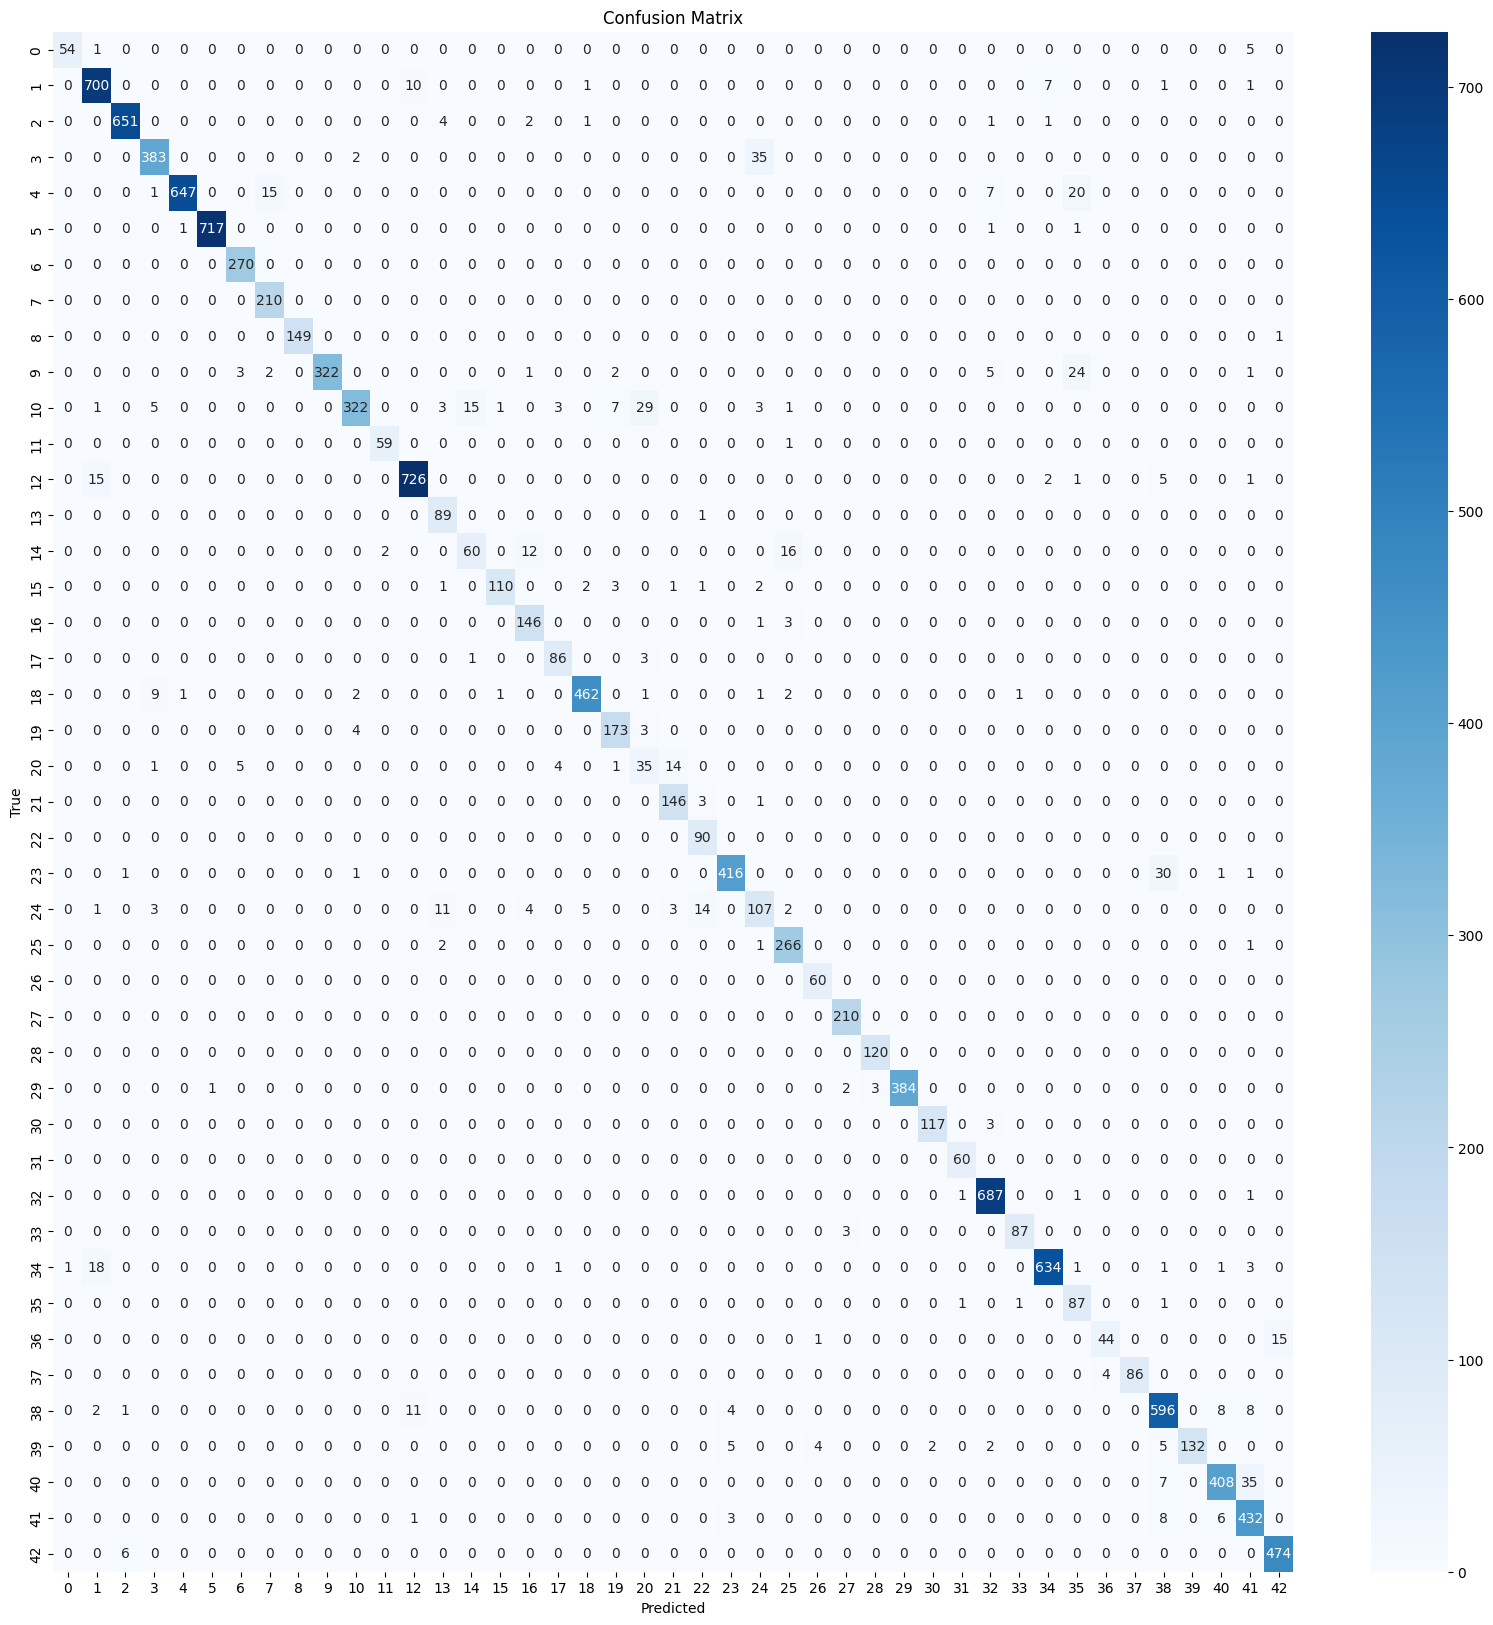


Worst performing classes:
Class 20: 58.33% accuracy
Class 14: 66.67% accuracy
Class 24: 71.33% accuracy
Class 36: 73.33% accuracy
Class 10: 82.56% accuracy


In [35]:
def evaluate_model(model, generator):
    # Get predictions
    y_pred = model.predict(generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Get true labels
    y_true = generator.classes
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes))
    
    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Find worst performing classes
    class_accuracy = np.diag(cm) / np.sum(cm, axis=1)
    worst_classes = np.argsort(class_accuracy)[:5]
    
    print("\nWorst performing classes:")
    for cls in worst_classes:
        print(f"Class {cls}: {class_accuracy[cls]*100:.2f}% accuracy")
        
    return y_pred, y_true

# Run the evaluation
y_pred, y_true = evaluate_model(model, test_generator)

# Checking inner indices mismatching for our classes

In [37]:
# Get the class mapping from your training data
train_class_indices = train_generator.class_indices

# Create a reverse mapping (index -> class name)
train_indices_class = {v: k for k, v in train_class_indices.items()}

# Print to check alignment
print("Train class mapping:", train_class_indices)
print("Test classes:", test_df['ClassId'].unique())

Train class mapping: {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '42': 37, '5': 38, '6': 39, '7': 40, '8': 41, '9': 42}
Test classes: ['16' '1' '38' '33' '11' '18' '12' '25' '35' '7' '23' '4' '9' '21' '20'
 '27' '3' '13' '10' '5' '17' '34' '2' '8' '30' '24' '15' '26' '28' '22'
 '14' '32' '29' '6' '36' '40' '41' '31' '19' '0' '39' '42' '37']


In [38]:
# model.load_weights("/kaggle/working/best_model.weights.h5")
# model.load_weights('/kaggle/working/fine_tuned_model.weights.h5', by_name=True, skip_mismatch=True)

In [39]:
# Run diagnostic on a batch from test generator
x_batch, y_batch = next(iter(test_generator))
pred_batch = model.predict(x_batch)

# Analyze the first few predictions
for i in range(min(5, len(x_batch))):
    pred_idx = np.argmax(pred_batch[i])
    true_idx = np.argmax(y_batch[i])
    print(f"Sample {i}: Predicted {pred_idx}, True {true_idx}")
    
    # Look up the actual class from your mapping
    if train_indices_class is not None:
        pred_class = train_indices_class[pred_idx] 
        print(f"Pred class: {pred_class}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
Sample 0: Predicted 8, True 8
Pred class: 16
Sample 1: Predicted 1, True 1
Pred class: 1
Sample 2: Predicted 32, True 32
Pred class: 38
Sample 3: Predicted 27, True 27
Pred class: 33
Sample 4: Predicted 3, True 3
Pred class: 11


In [40]:
test_df.columns

Index(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId',
       'Path'],
      dtype='object')

# Evaluating our model on single manual predictions

In [41]:
warnings_df=pd.read_csv("/kaggle/input/warnings/sign_warnings.csv")
warnings_df['ClassId']=warnings_df['ClassId'].astype(str)
test_df = test_df.merge(
    warnings_df[['ClassId','SignName', 'WarningMessage']].reset_index(),
    on='ClassId',
    how='left'
)
print(test_df.columns)

Index(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId',
       'Path', 'index', 'SignName', 'WarningMessage'],
      dtype='object')


In [49]:

# Fix the prediction function
def predict_single_image(image_path, confidence_threshold=0.5):
    # Load and show image
    show(image_path)
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Error: Image not found!")
        return "Unknown", 0.0

    # Process the image exactly as done in training
    # img = sharpen_image(img)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Predict
    pred = model.predict(img, verbose=0)
    confidence = np.max(pred)
    if confidence<confidence_threshold:
        print("Not sure about the outcome!!!Use ur brain")
    pred_index = int(np.argmax(pred))
    
    # Map index to real class label using reverse mapping
    pred_class_label = train_indices_class[pred_index]
        if test_df['ClassId'].dtype == 'int64':
        pred_class_label = int(pred_class_label)
    else:
        pred_class_label = str(pred_class_label)
    
    # Fetch sign info
    sign_info = test_df[test_df['ClassId'] == pred_class_label]    
    if not sign_info.empty:
        sign_info = sign_info.iloc[0]
        print(f"🚧 Sign Detected: {sign_info['SignName']}")
        print(f"⚠️ Warning: {sign_info['WarningMessage']}")
    else:
        print("❌ No matching information found for this class ID")

    print(f"\n✅ Confidence: {confidence * 100:.2f}%")

    return pred_class, confidence

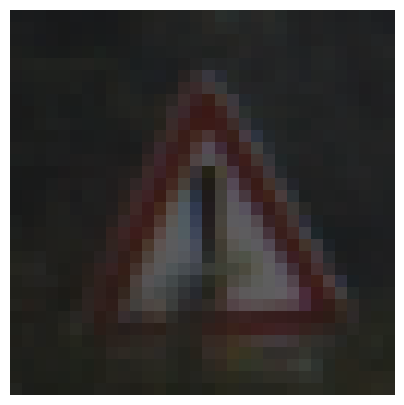

🚧 Sign Detected: General caution
⚠️ Warning: General caution ahead. Proceed with care.


('11', 0.57561594)

In [50]:
# show('/kaggle/input/gtsrb-german-traffic-sign/Meta/10.png')
predict_single_image("/kaggle/input/gtsrb-german-traffic-sign/Test/00164.png")
